In [1]:
import numpy as np, matplotlib.pyplot as plt, sys
from astropy.io import ascii as asc, fits as pyfits
from astropy import constants
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.ticker import MaxNLocator

% matplotlib inline

In [21]:
foutfile='FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.fout'
foutfile_GALEX='FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.GALEX.fout'
fileend=''
FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'

fout        = asc.read(FULL_PATH+foutfile,guess=False,Reader=asc.NoHeader)
stlr_mass   = np.array(fout['col7'])
fout_G      = asc.read(FULL_PATH+foutfile_GALEX,guess=False,Reader=asc.NoHeader)
stlr_mass_G = np.array(fout_G['col7'])

corr_tbl = asc.read(FULL_PATH+'Main_Sequence/mainseq_corrections_tbl.txt',guess=False,
                    Reader=asc.FixedWidthTwoLine)
iis = corr_tbl['ID'].data - 1

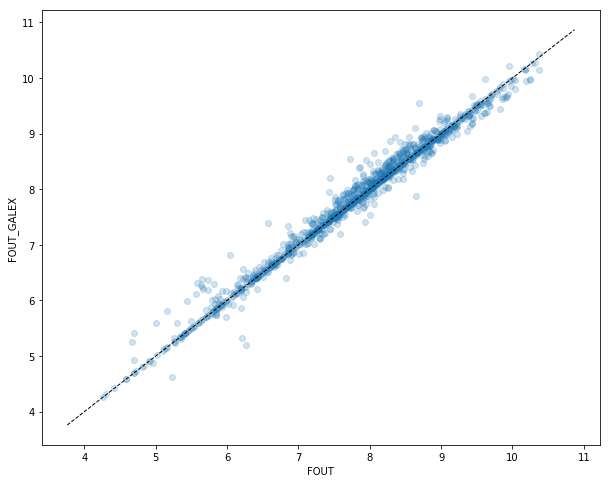

In [25]:
plt.plot(stlr_mass[iis], stlr_mass_G[iis], 'o', alpha=0.2)
plt.plot([min(stlr_mass[iis])-0.5, max(stlr_mass[iis])+0.5],
         [min(stlr_mass[iis])-0.5, max(stlr_mass[iis])+0.5], 'k--')
plt.xlabel('FOUT')
plt.ylabel('FOUT_GALEX')
plt.gcf().set_size_inches(10,8)

In [76]:
def modify_current_plot(current_axis, wavelength, flux, full_name, zs, stlr,
                        zp, chsq, AV, age, tau, filename):
    current_axis.plot(wavelength, flux)
#     current_axis.set_xscale('log')
    current_axis.set_yscale('log')
    current_axis.set_ylim(10**(-1), 10**(1.5))
    current_axis.set_xlim(3000, 25000)
    current_axis.tick_params(labelsize=9)
    current_axis.text(0.01, 0.95, full_name,
                      horizontalalignment='left', verticalalignment='top',
                      fontsize=10, transform=current_axis.transAxes)
    
    if 'NB711' in full_name or 'NB816' in full_name:    
        if 'A_V' not in filename and 'subplot' not in filename:
            current_axis.text(0.99, 0.59, r'${\chi}^2$'+'='+str(chsq)+
                              '\n'+r'$z_{\mathrm{spec}}=$'+str(np.around(zs, 4))+
                              '\n'+r'$\log(M/M_\odot)$='+str(stlr),
                              horizontalalignment='right',
                              verticalalignment='bottom', fontsize=10,
                              transform=current_axis.transAxes)
        else:
            current_axis.text(0.99, 0.59, 'M$_*$='+str(stlr)+
                              '\n'+r'${\chi}^2$'+'='+str(chsq)+
                              '\nA_V='+str(AV)+'\nlog(Age/yr)='+str(age)+
                              '\nlog('+r'$\tau$'+')='+str(tau),
                              horizontalalignment='right',
                              verticalalignment='bottom', fontsize=10,
                              transform=current_axis.transAxes)
    else:
        if 'A_V' not in filename and 'subplot' not in filename:
            current_axis.text(0.99, 0.05, r'${\chi}^2$'+'='+str(chsq)+
                              '\n'+r'$z_{\mathrm{spec}}=$'+str(np.around(zs, 4))+
                              '\n'+r'$\log(M/M_\odot)$='+str(stlr),
                              horizontalalignment='right',
                              verticalalignment='bottom', fontsize=10,
                              transform=current_axis.transAxes)
        else:
            current_axis.text(0.99, 0.05, 'M$_*$='+str(stlr)+
                              '\n'+r'${\chi}^2$'+'='+str(chsq)+
                              '\nA_V='+str(AV)+'\nlog(Age/yr)='+str(age)+
                              '\nlog('+r'$\tau$'+')='+str(tau),
                              horizontalalignment='right',
                              verticalalignment='bottom', fontsize=10,
                              transform=current_axis.transAxes)
    #endif

def plot_dotted_lines(zspec, zphot, axis, ymin, ymax):
    if zspec < 9.0 and zspec > 0.0:
        z = zspec
    else:
        z = zphot
    #endif

    lambda_vals = lambda_naught*(1+z)

    for (xpos, label) in zip(lambda_vals, lambda_label):
        axis.plot([xpos,xpos], [ymin,ymax], 'r:')
        axis.annotate(label, (xpos, ymin), va='bottom', ha='center',
                      rotation='vertical', fontsize=6, color='r')
    #endfor

def scatter_data(ID_num, axis):
    x_input_file = asc.read(FULL_PATH+'FAST/outputs/BEST_FITS/NB_IA_emitters_allphot.emagcorr.ACpsf_fast'+fileend+'_'+str(ID_num)+'.input_res.fit',guess=False,Reader=asc.NoHeader)
    x_input = np.array(x_input_file['col1'])
    y_index = np.where(y_input_id == ID_num)[0]

    y_input  = np.array([float(f_U[y_index]), f_B[y_index], f_V[y_index],
                         f_R[y_index], f_I[y_index], f_Z[y_index],
                         f_IA598[y_index], f_IA679[y_index], f_K[y_index],
                         f_ZB[y_index], f_ZR[y_index], f_J[y_index],
                         f_H[y_index]])
    yerr_arr = np.array([float(e_U[y_index]), e_B[y_index], e_V[y_index],
                         e_R[y_index], e_I[y_index], e_Z[y_index],
                         e_IA598[y_index], e_IA679[y_index], e_K[y_index],
                         e_ZB[y_index], e_ZR[y_index], e_J[y_index],
                         e_H[y_index]])
    if fileend=='.GALEX':
        y_input  = np.append(y_input, [f_NUV[y_index], f_FUV[y_index]])
        yerr_arr = np.append(yerr_arr, [e_NUV[y_index], e_FUV[y_index]])
    #endif
    axis.scatter(x_input, y_input, alpha=0.5, c='k', edgecolors='none')
    axis.errorbar(x_input, y_input, yerr=yerr_arr, fmt='none',
                  ecolor='k', alpha=0.5)

    shade_index = np.array([y for y in range(len(y_input))
                            if y_input[y] < -90.])
    if len(shade_index) > 0:
        for x in x_input[shade_index]:
            if x == 1522.35:   t_fwhm =  209 #FUV
            elif x == 2333.06: t_fwhm =  697 #NUV
            elif x == 16515.8: t_fwhm = 5700 #H
            elif x == 12528.1: t_fwhm = 1799 #J
            elif x == 22134.6: t_fwhm = 2995 #K
            axis.fill_between([x-t_fwhm/2.0, x+t_fwhm/2.0], 10**(-5), 10**(2.5),
                              color='k', alpha=0.3, edgecolor='none')
        #endfor
    #endif

def create_SED_fits(match_index, filename):
    print '###'+filename
    
    pp = PdfPages(FULL_PATH+'Plots/SED_fits/'+filename+'.pdf')

    filt_ID = ID0[match_index]
    filt_full = names[match_index]
    zphot_filt = zphot[match_index]
    zspec_filt = zspec0[match_index]
    stlr_filt = stlr_mass[match_index]
    chi2_filt = chi2[match_index]
    A_V_filt = A_V[match_index]
    lage_filt = lage[match_index]
    ltau_filt = ltau[match_index]

    for (ID_num, full_name, num, zp, zs, stlr, chsq, AV, age, tau) in zip(filt_ID, filt_full, range(len(filt_ID)), zphot_filt, zspec_filt, stlr_filt, chi2_filt, A_V_filt, lage_filt, ltau_filt):
        print ID_num
        tempfile = asc.read(FULL_PATH+'FAST/outputs/BEST_FITS/NB_IA_emitters_allphot.emagcorr.ACpsf_fast'+fileend+'_'+str(ID_num)+'.fit',guess=False,Reader=asc.NoHeader)
        wavelength = np.array(tempfile['col1'])
        flux = np.array(tempfile['col2'])
        
        flux *= 1E-19*((wavelength**2*1E-10)/(constants.c.value))#ergs/s/cm^2/Hz
        flux /= 1E-29 #microjanskys

        if num%5==0: #first on the page
            f, (ax0, ax1, ax2, ax3, ax4) = plt.subplots(5, sharex=True,
                                                        sharey=True)
            f.set_size_inches(6, 8)
            f.subplots_adjust(hspace=0.1)
            plt.xlim(10**3.0, 10**4.5)
            plt.xlabel('Observed Wavelength ('+r'$\AA$'+')', fontsize=12)
            plt.tick_params(labelsize=9)
        #endif
        axnum = num%5
        current_axis = f.get_axes()[axnum]

        modify_current_plot(current_axis, wavelength, flux, full_name, zs,
                            stlr, zp, chsq, AV, age, tau, filename)
        plot_dotted_lines(zs, zp, current_axis, min(current_axis.get_ylim()),
                          max(current_axis.get_ylim()))
        scatter_data(ID_num, current_axis)
        
        if num<4:
            plt.setp(current_axis.get_yticklabels(), visible=False)
        else:
            current_axis.set_ylabel('Flux ('+r'$\mu$'+'Jy)', fontsize=12)
        
        if axnum==4 or num==len(match_index)-1: #last on page
            plt.tight_layout()
            plt.subplots_adjust(hspace=0)
            pp.savefig()
            plt.close()
        #endif
    #endfor
    pp.close()

In [77]:
# create a SED plot w/ ea. of the 1 filters

In [85]:
# catfile='Catalogs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.cat'
# foutfile='FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.fout'
# fileend=''
catfile='Catalogs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.GALEX.cat'
foutfile='FAST/outputs/NB_IA_emitters_allphot.emagcorr.ACpsf_fast.GALEX.fout'
fileend='.GALEX'
FULL_PATH = '/Users/kaitlynshin/GoogleDrive/NASA_Summer2015/'

In [86]:
scatter_y_input = asc.read(FULL_PATH+catfile,guess=False,Reader=asc.CommentedHeader)
y_input_id = np.array(scatter_y_input['id'])
f_U     = np.array(scatter_y_input['f_U'])
e_U     = np.array(scatter_y_input['e_U'])
f_B     = np.array(scatter_y_input['f_B'])
e_B     = np.array(scatter_y_input['e_B'])
f_V     = np.array(scatter_y_input['f_V'])
e_V     = np.array(scatter_y_input['e_V'])
f_R     = np.array(scatter_y_input['f_R'])
e_R     = np.array(scatter_y_input['e_R'])
f_I     = np.array(scatter_y_input['f_I'])
e_I     = np.array(scatter_y_input['e_I'])
f_Z     = np.array(scatter_y_input['f_Z'])
e_Z     = np.array(scatter_y_input['e_Z'])
f_IA598 = np.array(scatter_y_input['f_IA598'])
e_IA598 = np.array(scatter_y_input['e_IA598'])
f_IA679 = np.array(scatter_y_input['f_IA679'])
e_IA679 = np.array(scatter_y_input['e_IA679'])
f_K     = np.array(scatter_y_input['f_K'])
e_K     = np.array(scatter_y_input['e_K'])
f_ZB    = np.array(scatter_y_input['f_ZB'])
e_ZB    = np.array(scatter_y_input['e_ZB'])
f_ZR    = np.array(scatter_y_input['f_ZR'])
e_ZR    = np.array(scatter_y_input['e_ZR'])
f_J     = np.array(scatter_y_input['f_J'])
e_J     = np.array(scatter_y_input['e_J'])
f_H     = np.array(scatter_y_input['f_H'])
e_H     = np.array(scatter_y_input['e_H'])
if fileend=='.GALEX':
    f_NUV = np.array(scatter_y_input['f_NUV'])
    e_NUV = np.array(scatter_y_input['e_NUV'])
    f_FUV = np.array(scatter_y_input['f_FUV'])
    e_FUV = np.array(scatter_y_input['e_FUV'])
#endif

fout      = asc.read(FULL_PATH+foutfile,guess=False,Reader=asc.NoHeader)
ID0       = np.array(fout['col1'])
zphot     = np.array(fout['col2'])
ltau      = np.array(fout['col3'])
lage      = np.array(fout['col5'])
A_V       = np.array(fout['col6'])
stlr_mass = np.array(fout['col7'])
sed_sfr   = np.array(fout['col8'])
chi2      = np.array(fout['col11'])

nbia = asc.read(FULL_PATH+'Catalogs/nb_ia_zspec.txt',guess=False,Reader=asc.CommentedHeader)
zspec0 = np.array(nbia['zspec0'])

nbia = pyfits.open(FULL_PATH+'Catalogs/NB_IA_emitters.nodup.colorrev.fix.fits')
nbiadata = nbia[1].data
names = nbiadata['NAME']

#+170815
Ha_corrs = pyfits.open(FULL_PATH+'Main_Sequence/Catalogs/mainseq_Ha_corrections'
                       +fileend+'.fits')
corrdata = Ha_corrs[1].data
ha_id = corrdata['ID']
dust_lumin0 = corrdata['dust_corr_lumin']

dust_lumin = np.zeros(len(ID0))
id_match = np.array([x for x in range(len(ID0)) if ID0[x] in ha_id])
dust_lumin[id_match] = dust_lumin0
print '### done reading files'

lambda_naught = np.array([912.0,1216.0,3727.0,(4861.0+5007.0)/2.0,6563.0])
lambda_label  = np.array(['Lyman break', 'Ly'+r'$\alpha$'+'', '[OII]',
                          'H'+r'$\beta$'+'+[OIII]', 'H'+r'$\alpha$'+''])

### done reading files


In [87]:
np.random.seed(436)
match_index0 = np.array([np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB704' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9])),
                         np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB711' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9])),
                         np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB816' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9])),
                         np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB921' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9])),
                         np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB973' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9]))])
create_SED_fits(match_index0, 'allfilt'+fileend)

###allfilt.GALEX
653
2356
3394
6214
7150


In [24]:
np.random.seed(433) # v1
match_index0 = np.array([np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB704' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9])),
                         np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB711' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9])),
                         np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB816' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9])),
                         np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB921' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9])),
                         np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB973' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9]))])
create_SED_fits(match_index0, 'allfilt'+fileend)

###allfilt
1222
2335
3724
5068
7304


In [11]:
np.random.seed(1) # v2
match_index0 = np.array([np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB704' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9])),
                         np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB711' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9])),
                         np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB816' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9])),
                         np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB921' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9])),
                         np.random.choice(np.array([x for x in range(len(names)) if 'Ha-NB973' in names[x] and len(names[x]) < 20 and zspec0[x] > 0 and zspec0[x] < 9]))])
create_SED_fits(match_index0, 'allfilt'+fileend)

###allfilt
406
1858
3346
5070
7499
